# Peer-to-peer Learning Contribution Measure Model (Income dataset)
This notebook implements a simple contribution model based on the notebook exemple of the DeAI repository. More precisely, it emulates a framework where `NUM_CLIENTS` clients are learning adult income prediction and average their models using a peer-to-peer learning setting (P2PL, i.e. without the orchestration of a central server).

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder

import time

# Custom functions
from helpers import *

# Visualization
from matplotlib import pyplot as plt
from visualization import *
plt.rc('legend', fontsize='small')
plt.style.use('bmh')

# Reproductibiity
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

# Console priniting option
np.set_printoptions(precision=3, suppress=False, sign=' ')

### Model 
`FC_Net` is strongly inspired by the model found in https://www.kaggle.com/chriszou/titanic-with-pytorch-nn-solution

In [2]:
from models import FC_Net

### Peer-to-peer Learning Contribution Measure
The following cells implement a peer-to-peer learning setting, i.e. where each user intitializes its own model and then,
for $r=1,...,$ `NUM_ROUNDS`:

1. Each client trains the model on its own data (`EPOCHS` times using batch of size `BATCH_SIZE`),
2. Each client send its model to a subset of other users participating to the task (according to a communication graph),
3. Each client recives the models from the other users,
4. Each client evaluates the performance of the models on its own test datasets,
5. Each client aggregates the models and update the contributions of each neighbouring user (in the communication graph).

### Data loading 
See `Income_FL.ipyn` for elementary analysis.

In [3]:
# loading
all_df, meta = load_into_df('income')

### Parameters (to be specified)

In [4]:
# Topology
NUM_CLIENTS = 4
COMM_MATRIX = np.array([[1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1]]) / NUM_CLIENTS

# Experiments
#SIZES = [0.4, 0.3, 0.2, 0.1]
#Y_ACC = [1., 1., 1., 1.]
#X_NOISE = [0., 0., 0., 0.]
#legends = SIZES

#SIZES = [0.25, 0.25, 0.25, 0.25]
#Y_ACC = [1., 0.98, 0.96, 0.94]
#X_NOISE = [0., 0., 0., 0.]
#legends = Y_ACC

SIZES = [0.25, 0.25, 0.25, 0.25]
Y_ACC = [1., 1., 1., 1.]
X_NOISE = [0., 0.1, 0.2, 0.3]
legends = X_NOISE

# Training parameters
NUM_ROUNDS = 100
EPOCHS = 1 #per round
LR = 1e-3
BATCH_SIZE = 32
F_TOT = 1
F_TEST = 0.3
THRESHOLD = 0.5
CRITERION = nn.BCELoss()
METRIC = 'loss_norm'
VERBOSE = True

# Model architecture
LIN_LAYERS_SIZES = [64, 16, 4]
OUTPUT_SIZE = 1

# Normalizing the datasets
all_df_norm = normalize(all_df, meta)

# Splitting the data into several datasets (train + test)
train_ds, test_ds = df_to_ds(all_df_norm, SIZES, meta, f_test=F_TEST, y_acc=Y_ACC, x_noise=X_NOISE)

# Creating the dataloaders
train_loaders = ds_to_dataloaders(train_ds, BATCH_SIZE)
test_loaders = ds_to_dataloaders(test_ds, 10*BATCH_SIZE, shuffle=False)
test_loader_s = ds_to_dataloaders(torch.utils.data.ConcatDataset(test_ds), 10*BATCH_SIZE, shuffle=False)

Sizes:
Full dataset: 48842
Splitted datasets (total): 48840 (train: 34188, test: 14652)
Per client: [12210, 12210, 12210, 12210]


### Marginal losses and Shapley values for P2PL

In [5]:
# initial model
initial_model = FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)
client_models = [FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE) for _ in range(NUM_CLIENTS)]

# coalition models and initialization
coal_models_agg = {} 
global_coals = {}
marg_coals = {}

for i, weights in enumerate(COMM_MATRIX.transpose()):
    
    client_models[i].load_state_dict(initial_model.state_dict())
    
    # tuple containing all the users that sends their model to user i (including i)
    global_coals[i] = tuple(np.nonzero(weights)[0])
    # all the leave-one-out caolitions that i can make when aggregating the models it recieved.
    for j in range(NUM_CLIENTS):
        marg_coals[i, j] = tuple([k for k in global_coals[i] if k != j])
    
    for coal in powerset(global_coals[i]):
        coal_models_agg[i, coal] = FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)
        coal_models_agg[i, coal].load_state_dict(initial_model.state_dict())

# performance measures
perf = initialize_perf((NUM_ROUNDS+1, NUM_CLIENTS)) # perf[0] contains the performance prior to learning
marg_perf_agg = initialize_perf((NUM_ROUNDS, NUM_CLIENTS, NUM_CLIENTS)) 
 
for i in range(NUM_CLIENTS):
    # untrained model performance
    fill_perf_history(evaluate_model(client_models[i], test_loaders[i], CRITERION, THRESHOLD),
                      perf, (0, i))
    
print('Prior performances ({}): {}'.format(METRIC, perf[METRIC][0, :]))

# contribution
SVa = np.zeros((NUM_ROUNDS, NUM_CLIENTS, NUM_CLIENTS))
MLa = np.zeros((NUM_ROUNDS, NUM_CLIENTS, NUM_CLIENTS))


# Iteration
for r in range(NUM_ROUNDS):
    t_start = time.time()
    if VERBOSE:
        print("------------------------------------\nRound {}:".format(r+1), end='')
    else:
        print("Round {}/{} (current {}: {})".format(r+1, NUM_ROUNDS, METRIC, perf[METRIC][r, :]), end='\r')
        
    # client update
    loss = {}
    for i, model in enumerate(client_models):
        opt = optim.SGD(model.parameters(), lr=LR)
        loss[i] = client_update(model, opt, CRITERION, train_loaders[i], epoch=EPOCHS)  
    
    # diffuse params across neighbors using different coalitions
    diffuse_params(client_models, coal_models_agg, COMM_MATRIX)

    # updating the client models with the aggregated model from the global coalitions
    for i, model in enumerate(client_models):
        model.load_state_dict(coal_models_agg[i, global_coals[i]].state_dict())
    
    # MLa
    for i in range(NUM_CLIENTS):
        
        # Computing the performance of each client models
        fill_perf_history(evaluate_model(client_models[i], test_loaders[i], CRITERION, THRESHOLD),
                          perf, (r+1, i))
        
        # step 5. Updating the contributions     
        # SVa
        SVa[r, i, :] = SV_P2PL(NUM_CLIENTS, i, global_coals[i], coal_models_agg, test_loaders[i], METRIC, CRITERION, THRESHOLD)
        
        #MLa
        for j in range(NUM_CLIENTS):
            # marginal models (during aggregation) performance on marginal test datasets
            fill_perf_history(evaluate_model(coal_models_agg[i, marg_coals[i, j]], test_loaders[i], CRITERION, THRESHOLD),
                              marg_perf_agg, (r, i, j))
        
        MLa[r, i, :] = marg_perf_agg[METRIC][r, i, :] - perf[METRIC][r+1, i]
    
    t_round = time.time() - t_start
    
    if VERBOSE:
        print(" ({:.1f}s)".format(t_round))
        print("Performance:\n{} ".format(perf[METRIC][r+1]))
        print("SVa:")
        print(" -Total:\n{}".format(SVa[r]))
        print(" -Cumulative:\n{}".format(SVa.sum(0)))
        print("MLa:")
        print(" -Total:\n{}".format(MLa[r]))
        print(" -Cumulative:\n{}".format(MLa.sum(0)))


print("------------------------------------\nFinal performance ({}): {}".format(METRIC, perf[METRIC][-1]))

Prior performances (loss_norm): [ 0.002  0.002  0.002  0.002]
------------------------------------
Round 1: (30.1s)
Performance:
[ 0.002  0.002  0.002  0.002] 
SVa:
 -Total:
[[ 5.457e-05  5.447e-05  6.996e-05  5.709e-05]
 [ 5.118e-05  5.206e-05  6.847e-05  5.388e-05]
 [ 3.549e-05  3.779e-05  5.498e-05  3.814e-05]
 [ 4.637e-05  4.715e-05  6.372e-05  4.876e-05]]
 -Cumulative:
[[ 5.457e-05  5.447e-05  6.996e-05  5.709e-05]
 [ 5.118e-05  5.206e-05  6.847e-05  5.388e-05]
 [ 3.549e-05  3.779e-05  5.498e-05  3.814e-05]
 [ 4.637e-05  4.715e-05  6.372e-05  4.876e-05]]
MLa:
 -Total:
[[-2.364e-06 -2.511e-06  6.083e-06 -1.182e-06]
 [-2.781e-06 -2.454e-06  6.773e-06 -1.501e-06]
 [-3.289e-06 -2.131e-06  7.456e-06 -1.980e-06]
 [-2.798e-06 -2.461e-06  6.793e-06 -1.658e-06]]
 -Cumulative:
[[-2.364e-06 -2.511e-06  6.083e-06 -1.182e-06]
 [-2.781e-06 -2.454e-06  6.773e-06 -1.501e-06]
 [-3.289e-06 -2.131e-06  7.456e-06 -1.980e-06]
 [-2.798e-06 -2.461e-06  6.793e-06 -1.658e-06]]
----------------------------

### Training history vizualization

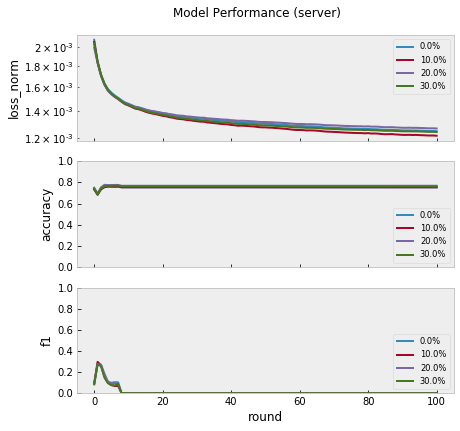

In [6]:
plotmetrics = ['loss_norm', 'accuracy', 'f1']

# Model performance
fig_perf = perfplots(perf, suptitle='Model Performance (server)', legends=legends, metrics=plotmetrics)


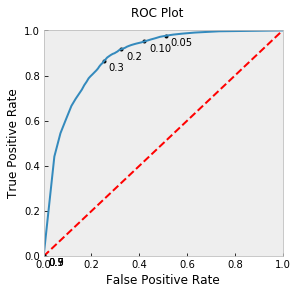

In [7]:
# ROC curve
fig_ROC = ROC(coal_models_agg[0, global_coals[0]], test_loader_s)

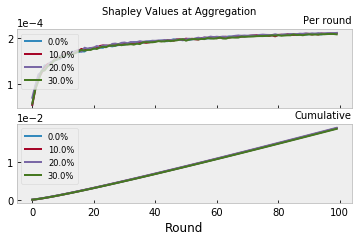

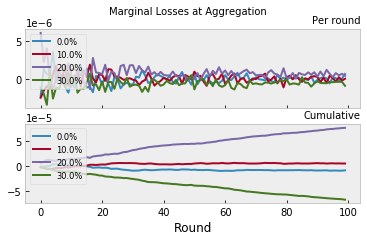

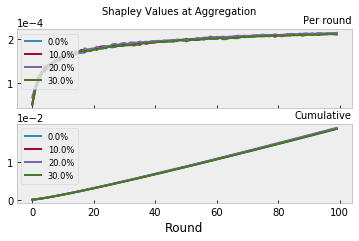

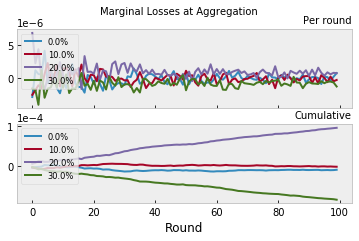

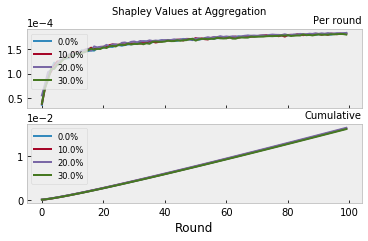

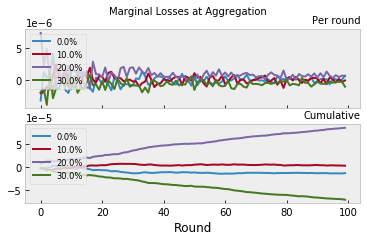

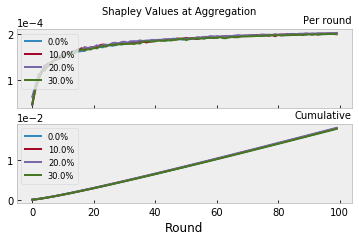

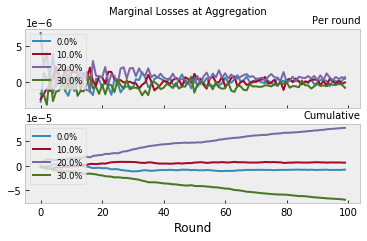

In [8]:
# Contribution plot
modes = ['round_maxmax', 'round_minmax', 'cum', 'minmax', 'maxmax']
modes = ['round', 'cum']
fig_SVa0 = contriplot(SVa[:,0,:], legends=legends, normalize=True, modes=modes, suptitle="Shapley Values at Aggregation")
fig_MLa0 = contriplot(MLa[:,0,:], legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses at Aggregation")
fig_SVa1 = contriplot(SVa[:,1,:], legends=legends, normalize=True, modes=modes, suptitle="Shapley Values at Aggregation")
fig_MLa1 = contriplot(MLa[:,1,:], legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses at Aggregation")
fig_SVa2 = contriplot(SVa[:,2,:], legends=legends, normalize=True, modes=modes, suptitle="Shapley Values at Aggregation")
fig_MLa2 = contriplot(MLa[:,2,:], legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses at Aggregation")
fig_SVa3 = contriplot(SVa[:,3,:], legends=legends, normalize=True, modes=modes, suptitle="Shapley Values at Aggregation")
fig_MLa3 = contriplot(MLa[:,3,:], legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses at Aggregation")

### Saving

In [9]:
from datetime import datetime
import dill
import os

### Saving the relevant objects
now = datetime.now()
time = now.strftime('%d_%m_%Hh%M')
subdir = "P2PL_n{}_r{}_{}/".format(NUM_CLIENTS, NUM_ROUNDS, time)

fig_dir = './saves/' + subdir + 'figures/'
save_dir = './saves/' + subdir

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
print(save_dir)

./saves/P2PL_n4_r100_04_06_21h25/


Figures

In [10]:
fig_perf.savefig(fig_dir + 'perf.png')
fig_ROC.savefig(fig_dir + 'ROC.png')
fig_SVa0.savefig(fig_dir + 'SVa0.png')
fig_MLa0.savefig(fig_dir + 'MLa0.png')
fig_SVa1.savefig(fig_dir + 'SVa1.png')
fig_MLa1.savefig(fig_dir + 'MLa1.png')
fig_SVa2.savefig(fig_dir + 'SVa2.png')
fig_MLa2.savefig(fig_dir + 'MLa2.png')
fig_SVa3.savefig(fig_dir + 'SVa3.png')
fig_MLa3.savefig(fig_dir + 'MLa3.png')

Variables

In [11]:
dill.dump_session(save_dir + 'variables.pckl')

### Loading

In [16]:
import dill
directory = './saves/FL_n4_r100_25_05_23h42/'
dill.load_session(directory + 'variables.pckl')